In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import random
import numpy as np
import matplotlib.pyplot as plt

import pybithumb as bithumb

Info for train samples
start time: 2020-10-01 12:00:00
end time: 2021-03-05 18:00:00

Info for test samples
start time: 2021-03-06 00:00:00
end time: 2021-05-11 15:00:00



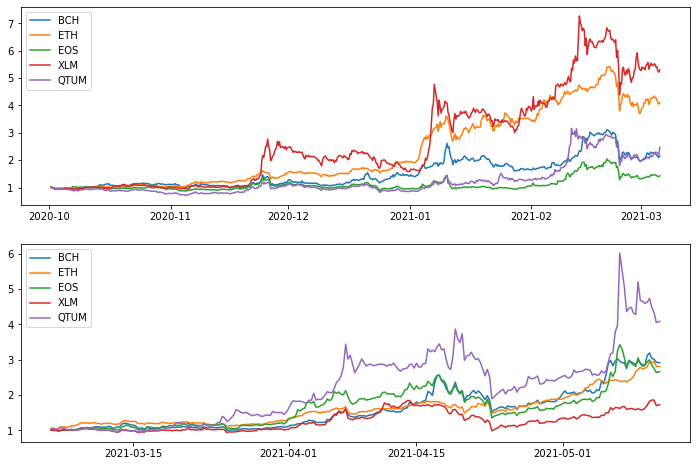

In [2]:
# import datasets
samples = dict()
coins = ["BCH", "ETH", "EOS", "XLM", "QTUM"]
init_balance = 1000000

# get data
train_samples = dict()
test_samples = dict()
for coin in coins:
    sample = bithumb.get_candlestick(coin, "KRW", chart_intervals="6h")
    sample = sample.iloc[-900:]
    ndays_high = sample['high'].rolling(window=10).max()
    ndays_low = sample['low'].rolling(window=10).min()
    sample['fast_k'] = (sample.close - ndays_low)/(ndays_high - ndays_low)
    sample['slow_d'] = sample['fast_k'].rolling(window=3).mean()
    sample['rtn'] = sample['close'].pct_change()
    sample.dropna(inplace=True)
    cut = int(len(sample.index)*0.7)
    train_sample = sample.iloc[:cut]
    test_sample = sample.iloc[cut:]
    train_sample['acc_rtn'] = (1 + train_sample['rtn']).cumprod()
    test_sample['acc_rtn'] = (1. + test_sample['rtn']).cumprod()

    train_samples[coin] = train_sample
    test_samples[coin] = test_sample

# info
print("Info for train samples")
print(f"""start time: {train_samples["BCH"].index[0]}""")
print(f"""end time: {train_samples["BCH"].index[-1]}""")
print()
print("Info for test samples")
print(f"""start time: {test_samples["BCH"].index[0]}""")
print(f"""end time: {test_samples["BCH"].index[-1]}""")
print()

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
for coin in coins:
    plt.plot(train_samples[coin].index, train_samples[coin].acc_rtn, label=coin)
plt.legend(loc='best')
plt.subplot(2, 1, 2)
for coin in coins:
    plt.plot(test_samples[coin].index, test_samples[coin].acc_rtn, label=coin)
plt.legend(loc='best')
plt.show()

In [3]:
# buy and hold
print("buy and hold - train")
weight = 0.
for coin in coins:
    sample = train_samples[coin]
    this_weight = sample['close'].iloc[-1]/sample['close'].iloc[0]
    print(f"{coin}: {this_weight}")
    weight += (0.2 * this_weight) 
print(f"total returns: {weight}")
print(f"final balance: {init_balance*weight}")
print()

print("buy and hold - test")
weight = 0.
for coin in coins:
    sample = test_samples[coin]
    this_weight = sample['close'].iloc[-1]/sample['close'].iloc[0]
    print(f"{coin}: {this_weight}")
    weight += (0.2 * this_weight) 
print(f"total returns: {weight}")
print(f"final balance: {init_balance*weight}")

buy and hold - train
BCH: 2.1325167037861914
ETH: 4.065288868013152
EOS: 1.4210700132100396
XLM: 5.2580937287751865
QTUM: 2.432762836185819
total returns: 3.061946429994078
final balance: 3061946.429994078

buy and hold - test
BCH: 2.8911917098445596
ETH: 2.747457627118644
EOS: 2.660934231931211
XLM: 1.704555129842486
QTUM: 3.890710382513661
total returns: 2.778969816250113
final balance: 2778969.816250113


In [6]:
# rebalancing every 6 hours
print("rebalancing - train")
balance = init_balance
for index in train_samples['BCH'].index:
    if index == train_samples['BCH'].index[0]:
        continue

    # get returns
    rtn = 0.
    for coin in coins:
        try:
            this_rtn = train_samples[coin]['close'].loc[index]/train_samples[coin]['close'].shift(1).loc[index]
        except:
            this_rtn = 1.
        rtn += (0.2 * this_rtn)
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()

print("rebalancing - test")
balance = init_balance
for index in test_samples['BCH'].index:
    if index == test_samples['BCH'].index[0]:
        continue

    # get returns
    rtn = 0.
    for coin in coins:
        try:
            this_rtn = test_samples[coin]['close'].loc[index]/test_samples[coin]['close'].shift(1).loc[index]
        except:
            this_rtn = 1.
        rtn += (0.2 * this_rtn)
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()


rebalancing - train
total returns: 3.037830693073775
final balance: 3037830.6930737747

rebalancing - test
total returns: 2.90335945930846
final balance: 2903359.4593084604



In [5]:
print("random rebalancing - train")
balance = init_balance
for index in train_samples['BCH'].index:
    if index == train_samples['BCH'].index[0]:
        continue
    # get weights
    randoms = dict()
    weights = dict()

    for coin in coins:
        randoms[coin] = random.random()
        #print(f"{index} {coin} {weights[coin]}")

    for coin in coins:
        weights[coin] = randoms[coin]/sum(randoms.values())  

    # get returns
    rtn = 0.
    for coin in coins:
        this_rtn = train_samples[coin]['close'].loc[index]/train_samples[coin]['close'].shift(1).loc[index]
        rtn += (weights[coin] * this_rtn)
    # sold all because of negative momentum
    if rtn == 0.:
        rtn = 1.
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()

# rebalancing every one hours
print("random rebalancing - test")
balance = init_balance
for index in test_samples['BCH'].index:
    if index == test_samples['BCH'].index[0]:
        continue

    # get weights
    randoms = dict()
    weights = dict()

    for coin in coins:
        randoms[coin] = random.random()
        #print(f"{index} {coin} {weights[coin]}")

    for coin in coins:
        weights[coin] = randoms[coin]/sum(randoms.values()) 

    # get returns
    rtn = 0.
    for coin in coins:
        this_rtn = test_samples[coin]['close'].loc[index]/test_samples[coin]['close'].shift(1).loc[index]
        rtn += (weights[coin] * this_rtn)
    # sold all because of negative momentum
    if rtn == 0.:
        rtn = 1.
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()

random rebalancing - train
total returns: 2.926737915704382
final balance: 2926737.9157043817

random rebalancing - test
total returns: 2.9123346105716843
final balance: 2912334.6105716843



In [7]:
# rebalancing every one hours
print("momentum rebalancing - train")
balance = init_balance
for index in train_samples['BCH'].index:
    if index in train_samples['BCH'].index[0:9]:
        continue

    # get weights
    momentums = dict()
    weights = dict()
    for coin in coins:
        close_1f_ago = train_samples[coin].shift(1).loc[index, 'close']
        close_9f_ago = train_samples[coin].shift(9).loc[index, 'close']
        this_mom = (close_1f_ago - close_9f_ago)/close_9f_ago
        # block negative momentum
        momentums[coin] = max(this_mom, 0.)

    for coin in coins:
        if sum(momentums.values()) == 0:
            weights[coin] = 0.
        else:
            weights[coin] = momentums[coin]/sum(momentums.values())
        #print(f"{index} {coin} {weights[coin]}")

    # get returns
    rtn = 0.
    for coin in coins:
        this_rtn = train_samples[coin]['close'].loc[index]/train_samples[coin]['close'].shift(1).loc[index]
        rtn += (weights[coin] * this_rtn)
    # sold all because of negative momentum
    if rtn == 0.:
        rtn = 1.
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()

# rebalancing every one hours
print("momentum rebalancing - test")
balance = init_balance
for index in test_samples['BCH'].index:
    if index in test_samples['BCH'].index[0:9]:
        continue

    # get weights
    momentums = dict()
    weights = dict()
    for coin in coins:
        close_1f_ago = test_samples[coin].shift(1).loc[index, 'close']
        close_9f_ago = test_samples[coin].shift(9).loc[index, 'close']
        this_mom = (close_1f_ago - close_9f_ago)/close_9f_ago
        # block negative momentum
        momentums[coin] = max(this_mom, 0.)
    
    for coin in coins:
        if sum(momentums.values()) == 0:
            weights[coin] = 0.
        else:
            weights[coin] = momentums[coin]/sum(momentums.values())

    # get returns
    rtn = 0.
    for coin in coins:
        this_rtn = test_samples[coin]['close'].loc[index]/test_samples[coin]['close'].shift(1).loc[index]
        rtn += (weights[coin] * this_rtn)
    # sold all because of negative momentum
    if rtn == 0.:
        rtn = 1.
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()

momentum rebalancing - train
total returns: 3.5933149631795036
final balance: 3593314.9631795036

momentum rebalancing - test
total returns: 2.5337376389718913
final balance: 2533737.6389718913



In [8]:
print("slow-d rebalancing - train")
balance = init_balance
for index in train_samples['BCH'].index:
    if index in train_samples['BCH'].index[0:13]:
        continue

    # get weights
    slow_d = dict()
    weights = dict()
    for coin in coins:
        close_1f_ago = train_samples[coin].shift(1).loc[index, 'close']
        close_9f_ago = train_samples[coin].shift(9).loc[index, 'close']
        this_mom = (close_1f_ago - close_9f_ago)/close_9f_ago
        slow_d[coin] = train_samples[coin].shift(1).loc[index, 'slow_d']
        if this_mom < 0:
            slow_d[coin] = 0.

    for coin in coins:
        try:
            weights[coin] = slow_d[coin]/sum(slow_d.values())
        except:
            weights[coin] = 0. 
        #print(f"{index} {coin} {weights[coin]}")

    # get returns
    rtn = 0.
    for coin in coins:
        this_rtn = train_samples[coin]['close'].loc[index]/train_samples[coin]['close'].shift(1).loc[index]
        rtn += (weights[coin] * this_rtn)
    # sold all because of negative momentum
    if rtn == 0.:
        rtn = 1.
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()

# rebalancing every one hours
print("slow-d rebalancing - test")
balance = init_balance
for index in test_samples['BCH'].index:
    if index in test_samples['BCH'].index[0:9]:
        continue

    # get weights
    slow_d = dict()
    weights = dict()
    for coin in coins:
        close_1f_ago = test_samples[coin].shift(1).loc[index, 'close']
        close_9f_ago = test_samples[coin].shift(9).loc[index, 'close']
        this_mom = (close_1f_ago - close_9f_ago)/close_9f_ago
        slow_d[coin] = test_samples[coin].shift(1).loc[index, 'slow_d']
        if this_mom < 0:
            slow_d[coin] = 0.
    
    for coin in coins:
        try:
            weights[coin] = slow_d[coin]/sum(slow_d.values())
        except:
            weights[coin] = 0. 

    # get returns
    rtn = 0.
    for coin in coins:
        this_rtn = test_samples[coin]['close'].loc[index]/test_samples[coin]['close'].shift(1).loc[index]
        rtn += (weights[coin] * this_rtn)
    # sold all because of negative momentum
    if rtn == 0.:
        rtn = 1.
    balance *= rtn
print(f"total returns: {balance/init_balance}")
print(f"final balance: {balance}")
print()

slow-d rebalancing - train
total returns: 3.3019407292898504
final balance: 3301940.72928985

slow-d rebalancing - test
total returns: 2.706456927428992
final balance: 2706456.927428992

